In [197]:
from torch.utils.data import DataLoader
from train import Trainer
from models import Generator, Critic
import os
import data.data_preprocessing as data_prep
import torch
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import shutil

We found the model having some problems when generate really small values, for that reason we scaled the series by a factor of 100 when training the model. Than It's necessary to divide by a factor of 100 the raw model output. 

In [198]:
#create the transformer to scale the series
class ScaleInput:

    def __call__(slef, sample):
        return sample * 100

class MinMaxScaler:

    def __init__(self, range = (0,1)):
        self.min = range[0]
        self.max = range[1]

    def __call__(self, sample):

        cap = torch.max(sample)
        bottom = torch.min(sample)

        X_std = (sample - bottom) / (cap - bottom)
        X_scaled = X_std * (self.max - self.min) + self.min
        
        return X_scaled

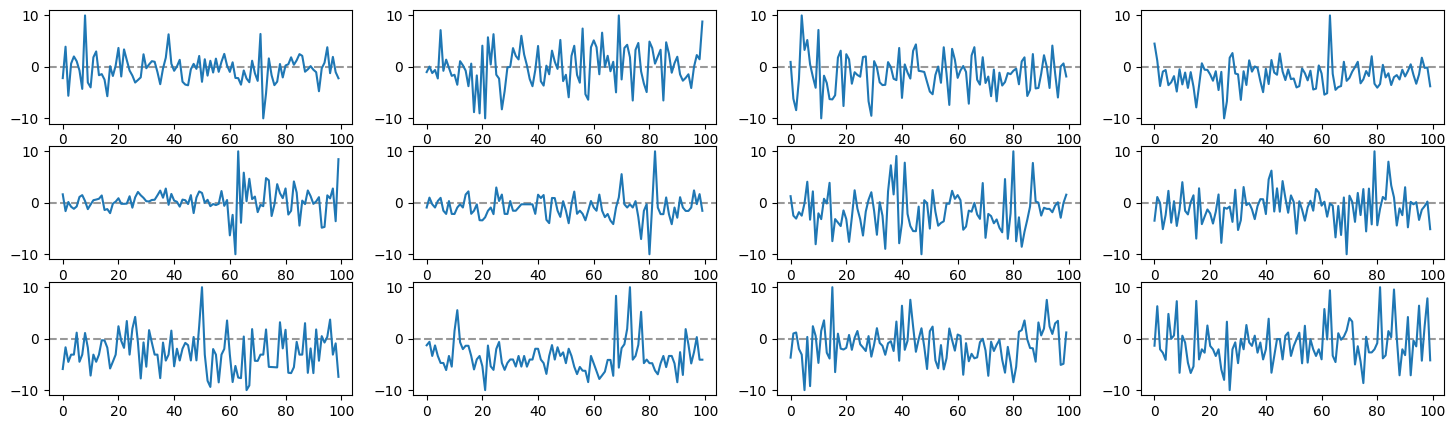

In [199]:
scaler = MinMaxScaler(range = (-10,10))
#create the dataloader
dataset = data_prep.WindowsDaset(r'data\dataset_100_winds',transform = scaler)
#plotsome series
rows = 3
columns = 4
fig, axs = plt.subplots(rows, columns, figsize=(18,5))
for ax, i in zip(axs.ravel(),np.random.randint(0, len(dataset),size=rows * columns)):
    ax.axhline(0, color = 'black', alpha =0.4, ls = '--')
    ax.plot(dataset[i])

In [200]:
def create_dir(location, name):
    os.mkdir(os.path.join(location, name))
    shutil.copy('models.py', os.path.join(location, name))
    os.mkdir(os.path.join(location, name, 'training_samples'))
    os.mkdir(os.path.join(location, name, 'checkpoints'))
    os.mkdir(os.path.join(location, name, 'training_samples','dynamic_latents'))
    os.mkdir(os.path.join(location, name, 'training_samples','fixed_latents'))
    return os.path.join(location, name)

In [239]:
BASE_DIR = r'C:\Users\bolla\Desktop\CUHK_courses\IASP_elisa\runs'

#global variables for the run
GP_WEIGHT = 10
CRITIC_IT = 5
PRINT_EVERY = 10
CHECKPOINT_FREQ = 10
BATCH_SIZE = 256
LOG_NAME = 'run_1_0'
EPOCHS = 40

run_ARCHIVE = create_dir(BASE_DIR,'000_003/000_006')

In [223]:
#create the dataloader
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)

In [224]:
import importlib
import models
importlib.reload(models)
from models import Generator, Critic

import train
importlib.reload(train)
from train import Trainer

In [242]:
from checkpoints import models as models_test

In [244]:
# Instantiate Generator and Critic + initialize weights
if True:
    state_dicts = torch.load('checkpoints/epoch_39.pkl', map_location=torch.device('cpu'))
    

    g = models_test.Generator()
    g.load_state_dict(state_dicts['g_state_dict'])
    g_opt = torch.optim.RMSprop(g.parameters(), lr=0.05)
    #adam optimizer beta1 = 0.5 beta2 .99 lr = 0.003
    #grater for discriminator the lr


    c = models_test.Critic()
    c.load_state_dict(state_dicts['d_state_dict'])
    c_opt = torch.optim.RMSprop(c.parameters(), lr=0.05)
    
else:

    g = Generator()
    g_opt = torch.optim.RMSprop(g.parameters(), lr=0.1)

    c = Critic()
    c_opt = torch.optim.RMSprop(c.parameters(), lr=0.05)

log_name = LOG_NAME
# Instantiate Tensorboard writer
tb_logdir = os.path.join('tensorboard', log_name)
writer = SummaryWriter(log_dir=tb_logdir)

# Instantiate Trainer
trainer = Trainer(g, c, g_opt, c_opt,GP_WEIGHT,CRITIC_IT,PRINT_EVERY,CHECKPOINT_FREQ, writer=writer, ARCHIVE_DIR=run_ARCHIVE)
# Train model
print('Training is about to start...')

trainer.train(data_loader, epochs=EPOCHS, plot_training_samples=True, checkpoint=None)

Training is about to start...


100%|██████████| 40/40 [45:45<00:00, 68.64s/it]


In [354]:
# the following function allow to generate a sample to test the model
def generate_sample(model, out_tensor : bool, plot = True):
    pr = model(torch.rand((1,50)))
    if plot:
        plt.plot(pr.detach().numpy()[0]/100)
        plt.axhline(0)
        
    #plt.ylim(-1,1)
    if out_tensor == True:
        return pr.detach().numpy()[0]

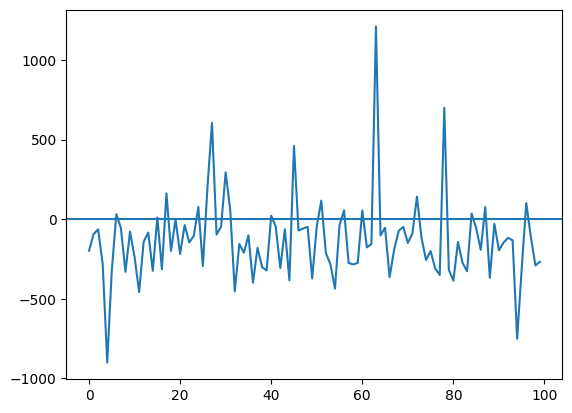

In [355]:
pr_r = generate_sample(g, out_tensor = True)

In [258]:
from tqdm import tqdm
dataset_refine = data_prep.WindowsDaset(r'data\dataset_100_winds')

maxes = np.zeros(len(dataset_refine))
mins  = np.zeros(len(dataset_refine))
for index, i in tqdm(enumerate(dataset_refine)):
    maxes[index] = i.max().item()
    mins[index]  = i.min().item()

q_max   = np.quantile(maxes,[0.1 * i for i in range(1,10)])
q_min   = np.quantile(abs(mins),[0.1 * i for i in range(1,10)])*-1

distances_max = np.zeros(len(dataset_refine))
for index, i in tqdm(enumerate(dataset_refine)):
    max_2, max_1 = (i.sort()[0][-2:])
    distances_max[index] = max_1 - max_2

distances_min = np.zeros(len(dataset_refine))
for index, i in tqdm(enumerate(dataset_refine)):
    min_1, min_2 = (i.sort()[0][:2])
    distances_min[index] = abs(min_2) - abs(min_1)

dist_q_max = np.quantile(distances_max,[0.1 * i for i in range(1,10)])
dist_q_min = np.quantile(distances_min,[0.1 * i for i in range(1,10)])

10353it [00:56, 183.83it/s]
10353it [00:57, 180.88it/s]
10353it [00:58, 178.34it/s]


In [259]:
dist_q_max

array([0.00102318, 0.00225833, 0.00370262, 0.00539146, 0.00756269,
       0.01049278, 0.01471854, 0.0216898 , 0.0358385 ])

In [262]:
def scale_sample(q_dist_max, q_dist_min ,sample, q_max ,q_min):
    max_2, max_1 = (sample.sort()[0][-2:])
    dist = max_1 - max_2
    dist = (dist/(abs(sample.min())+sample.max())).item()

    sorted_q   = np.sort(np.append(q_dist_max,dist))
    dist_index =  np.where(sorted_q == dist)[0]
    if dist_index == 9:
        low_rnd_max = q_max[8]
        up_rnd_max  = q_max[8]+0.1
    elif dist_index == 0:
        up_rnd_max  = q_max[0]
        low_rnd_max = q_max[0] -0.01
    else:
        low_rnd_max = q_max[dist_index-1]
        up_rnd_max  = q_max[dist_index]
    
    max_pick = np.random.uniform(low=low_rnd_max, high=up_rnd_max)

    #pick value for min
    min_1, min_2 = (sample.sort()[0][:2])
    dist_min = abs(min_2) - abs(min_1)
    dist_min = (dist_min/(abs(sample.min())+sample.max())).item()

    sorted_q_min   = np.sort(np.append(q_dist_min,dist_min))
    dist_index_min =  np.where(sorted_q_min == dist_min)[0]

    if dist_index_min == 9:
        low_rnd_min = q_min[8]
        up_rnd_min  = q_min[8]+0.01
    elif dist_index_min == 0:
        up_rnd_min  = q_min[0]
        low_rnd_min = q_min[0] -0.1
    else:
        low_rnd_min = q_min[dist_index_min-1]
        up_rnd_min = q_min[dist_index_min]
    min_pick = np.random.uniform(low=low_rnd_min, high=up_rnd_min)


    print(min_pick)
    max_sample = sample.max().item()
    min_sample = sample.min().item()

    X_std = (sample - min_sample) / (max_sample - min_sample)
    X_scaled = X_std * (max_pick - min_pick) + min_pick

    return X_scaled

In [271]:
import rescale_generated
importlib.reload(rescale_generated)
from rescale_generated import Rescale

~Scaler initialization~
~computing the min and max quantiles~


100%|██████████| 10353/10353 [00:56<00:00, 184.54it/s]


~computing the distance between peaks~


100%|██████████| 10353/10353 [00:57<00:00, 178.96it/s]


TypeError: Rescale.scale() missing 1 required positional argument: 'sample'

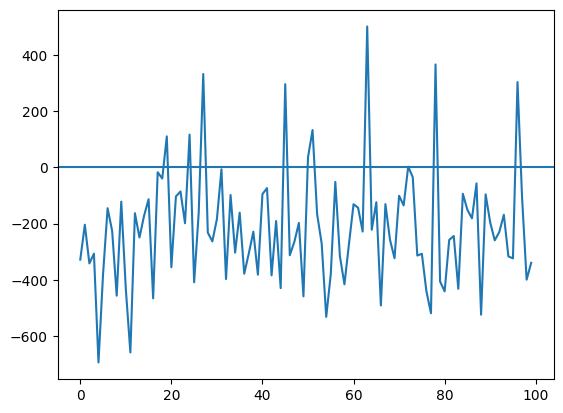

In [272]:
rescaler = Rescale(dataset_refine)

-0.060805983880174067


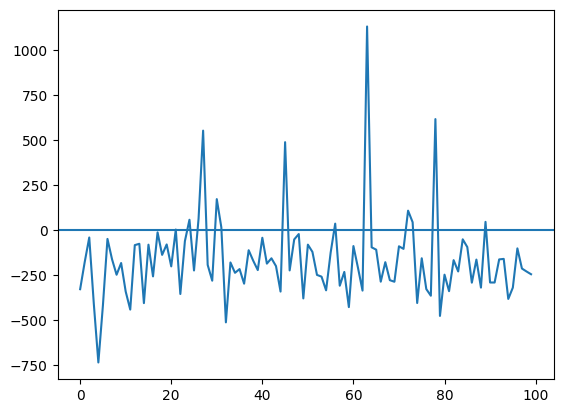

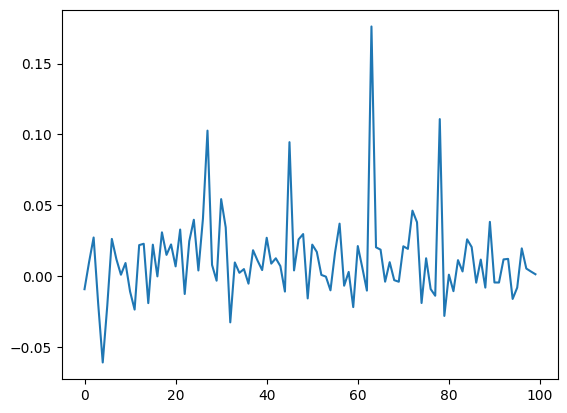

In [378]:
generated_sample = generate_sample(g, out_tensor = True)
scaled_p = rescaler.scale(sample = torch.tensor(generated_sample))
plt.figure(facecolor='white')
plt.plot(scaled_p)

In [379]:
generated_price = []
init = 1
for i in scaled_p:
    init = init + init * i.item()
    generated_price.append(init)

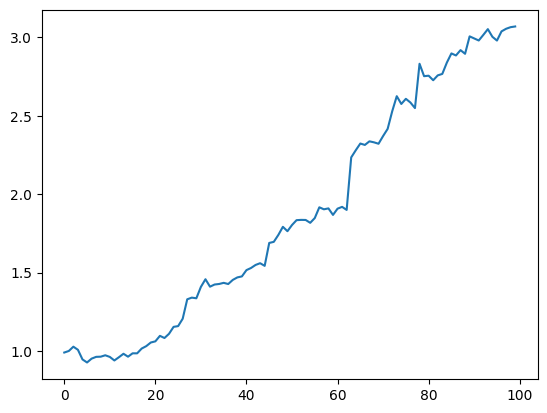

In [380]:
plt.plot(generated_price)